# Tutorial for implementing pathwise optimization algorithms

In [1]:
import torch

from xopt import Xopt
from xopt.vocs import VOCS
from xopt.generators.bayesian.bax_generator import BaxGenerator
from xopt.evaluator import Evaluator

import numpy as np
import random

import math
import matplotlib.pyplot as plt

# Ignore all warnings
import warnings

warnings.filterwarnings("ignore")

# random seeds for reproducibility
rand_seed = 2

torch.manual_seed(rand_seed)
np.random.seed(rand_seed)  # only affects initial random observations through Xopt
random.seed(rand_seed)

In [2]:
# define variables and function objectives
vocs = VOCS(
    variables={"x0": [0, 2 * math.pi],
              },
    observables=["y1"],
)

In [3]:
# define a test function to optimize
def sin_function(input_dict):
    return {"y1": np.sin(input_dict["x0"])}

In [4]:
from bax_algorithms.pathwise.base import PathwiseOptimization
from botorch.models.model import Model
from torch import Tensor

# define a simple algorithm to minimize the observable "y1"
class PathwiseMinimize(PathwiseOptimization):

    def perform_virtual_measurement(
        self,
        model: Model,
        x: Tensor,
        bounds: Tensor,
        n_samples: int = None,
        tkwargs: dict = None,
    ) -> Tensor:

        virtual_objective = self.evaluate_virtual_observables(model, x, n_samples)

        return {'objective': virtual_objective}

In [5]:
# Prepare BAX algorithm and generator options
from bax_algorithms.pathwise.optimize import DifferentialEvolution
algorithm = PathwiseMinimize(n_samples=10,
                             observable_names_ordered=['y1'],
                             optimizer = DifferentialEvolution(minimize=True)
)

# construct BAX generator
generator = BaxGenerator(vocs=vocs, algorithm=algorithm)
generator.gp_constructor.use_low_noise_prior = True

In [6]:
# construct evaluator
evaluator = Evaluator(function=sin_function)

# construct Xopt optimizer
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

In [7]:
# evaluate initial points
X.random_evaluate(3)

# inspect the gathered data
X.data

,x0,y1,xopt_runtime,xopt_error
0,3.543749,-0.391403,9.700016e-06,False
1,6.120286,-0.162180,1.600012e-06,False
2,2.829554,0.306999,9.000069e-07,False


In [8]:
import time

# do BAX iterations
for i in range(10):
    print(i)
    start=time.time()
    X.step()
    print(time.time()-start)

0
1.4914929866790771
1
0.9828262329101562
2
0.4639618396759033
3
1.407714605331421
4
0.6699490547180176
5
0.6113085746765137
6
0.740180253982544
7
0.7463443279266357
8
0.7276651859283447
9
0.6713650226593018


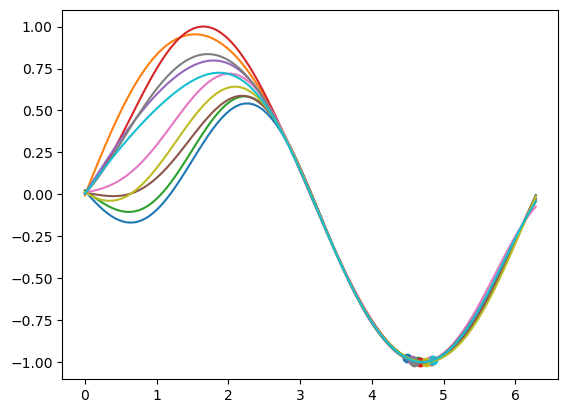

In [9]:
# evaluate sample functions from last iteration on a linspace and plot virtual optimization results
from matplotlib import pyplot as plt
x = torch.linspace(0, 2*torch.pi, 100)
y = X.generator.algorithm.results['sample_functions_list'][0](x.reshape(-1,1))
for i in range(y.shape[0]):
    plt.plot(x,y[i].flatten().detach())
    plt.scatter(X.generator.algorithm.results['best_inputs'][i].flatten(), X.generator.algorithm.results['best_objective'][i].detach().flatten())

0.0900881290435791


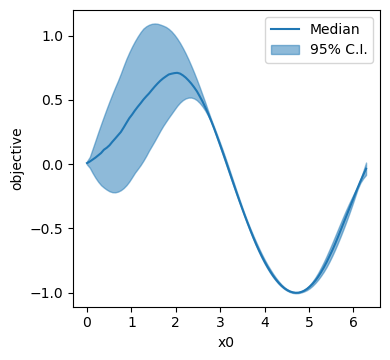

In [10]:
from bax_algorithms.visualize import visualize_virtual_measurement_result
X.generator.train_model()

start = time.time()
fig, ax = visualize_virtual_measurement_result(X.generator, 
                            variable_names=['x0'],
                            reference_point={'x0':torch.tensor([0.])},
                            n_grid=100,
                            n_samples=100,
                                     )
print(time.time()-start)

In [11]:
from bax_algorithms.utils import get_bax_mean_prediction, tuning_input_tensor_to_dict
mean_optimizer = DifferentialEvolution(minimize=True, maxiter=100, verbose=True)
x_tuning = get_bax_mean_prediction(X.generator, mean_optimizer)
x_tuning_dict = tuning_input_tensor_to_dict(X.generator, x_tuning)
print(x_tuning)
print(x_tuning_dict)

Beginning BAX virtual optimization.
BAX virtual optimization took: 0.008124828338623047 seconds.
tensor([[4.7169]], dtype=torch.float64)
{'x0': 4.716868467078873}
